In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def bedtopo(L,*args):  #bed to topography L- length of glacier
    b0 = args[0]   #b0: glacier start point
    bx = args[1]   #bx: glacier slope
    sillmin = args[2]   #start of reverse slope
    sillmax = args[3]   #end of reverse slope
    sillslope = args[4]   #slope of reverse slope
    
    if L < sillmin: #if glacier is shorter than reverse slope
        b = b0 + bx*L
    elif L < sillmax: #if glacier terminates on reverse slope
        b = b0 + bx*sillmin + sillslope*(L-sillmin)
    else: #if glacier terminates after reverse slope
        b = b0 + bx*sillmin + sillslope*(sillmax-sillmin) + bx*(L-sillmax)
        
    return b

In [3]:
def TwoStage_timedep(state,*args): #Robel et al. 2018 two-stage model
    
    Hnd, Lnd = state #Unpack the state vector, Hnd n-dim thickness
    #Lnd n-dim length
    f = np.zeros(2) #Derivatives
    
    smb0 = args[0] #P (precipitation) at time 0
    smb1 = args[1] #P (precipitation) at time 1
    smbf = args[2] #P (precipitation) at time f
    gamma = args[3] #Q coefficient
    omega = args[4] #Q_g coefficient
    time = args[5]
    t1 = args[6]
    tfinal = args[7]
#    b0 = args[3]
#    bx = args[4]
#    sillmin = args[5]
#    sillmax = args[6]
#    sillslope = args[7]

    b0 = 0   #glacier start point
    bx = args[11]   #glacier slope
    sillmin = args[8]*1e3   #reverse slope start point
    sillmax = args[9]*1e3   #reverse slope ends point
    sillslope = args[10]    #reverse slope slope
    
    rhow = 1028   #density of water
    rhoi = 917   #denisty of ice
    n = 3   
    beta = 3 
    Lscale = 100e3   #scale for length, it is on the order of 10E4 or 1E5
    Hscale = 1000   #scale for thickness, it is on the order of 10E2 or 1E3
    
    H = Hnd*Hscale #icethickness
    L = Lnd*Lscale #length of glacier
    
    if time < t1:
        smb = smb0 + (smb1-smb0)*time/t1
    else:
        smb = smb1 + (smbf-smb1)*time/(tfinal-t1) 
    #see below for write out of the functions in mathematical notation
    hg = -(rhow/rhoi)*bedtopo(L,b0,bx,sillmin,sillmax,sillslope)   # #1
    Q = gamma * (H**(2*n + 1))/(L**n)   # #2
    Qg = omega * (hg**beta)   # #3
    
    f[0] = (smb - (Qg/L) - (H/(hg*L))*(Q-Qg))/Hscale   # #4
    f[1] = (Q-Qg)/hg/Lscale   # #5
    return f 

In [4]:
def RK4(rhs,state,dt,*args): #ask for explanation
    
    k1 = rhs(state,*args)
    k2 = rhs(state+k1*dt/2,*args)
    k3 = rhs(state+k2*dt/2,*args)
    k4 = rhs(state+k3*dt,*args)

    new_state = state + (dt/6)*(k1+2*k2+2*k3+k4)
    return new_state

In [5]:
def EnKF(ubi,w,ObsOp,JObsOp,R,B,N):
    
    # The analysis step for the (stochastic) ensemble Kalman filter 
    # with virtual observations

    n,N = ubi.shape # n is the state dimension and N is the size of ensemble
    m = w.shape[0] # m is the size of measurement vector

    # compute the mean of forecast ensemble
    ub = np.mean(ubi,1)
    # compute Jacobian of observation operator at ub
    Dh = JObsOp(w)
    # compute Kalman gain
    D = Dh@B@Dh.T + R #@ is matrix multiplication
    K = B @ Dh.T @ np.linalg.inv(D)
    Q=np.cov(ubi)
    ubi=ubi+np.random.multivariate_normal(np.zeros(n),Q,size=N).T

    wi = np.zeros([m,N])
    uai = np.zeros([n,N])
    for i in range(N):
        # create virtual observations
        wi[:,i] = w + np.random.multivariate_normal(np.zeros(m), R)
        # compute analysis ensemble
        uai[:,i] = ubi[:,i] + K @ (wi[:,i]-ObsOp(ubi[:,i]))
        
    # compute the mean of analysis ensemble
    ua = np.mean(uai,1)    
    # compute analysis error covariance matrix
    P = (1/(N-1)) * (uai - ua.reshape(-1,1)) @ (uai - ua.reshape(-1,1)).T
    ve=np.linalg.norm(P)
    return uai, P, ve

In [6]:
# Observation operators
def h(u):   #identity oberservation operator?
    w = u
    return w

def Dh(u):   #identity operator for matrix of size Dh
    n = len(u)
    D = np.eye(n)
    return D

In [7]:
err = {}

In [8]:
#load in data and turn it into the uTrue
u=pd.read_csv("data_matrix_4/smbt11950smbtf2300smb00.324smb10.162smbf-0.015sillmin415sillmax425sillslope0.01hnd2.35lnd4.6bx-0.001.csv")
b=np.zeros((len(u),2))
b[:,0]=u["H"]
b[:,1]=u["L"]
uTrue=b.T

In [9]:
nd = 2 #degrees of freedom (number of prognositic equations in model)
# parameters
smb0 = 0.324
smb1 = 0.162
smbf = -0.015
t1 = 1950
gamma = 0.05
omega = 8e-8
#b0 = 0
bx = -0.001
sillmin = 415
sillmax = 425
sillslope = 0.01

dt = 0.25
tm = 2300
nt = int(tm/dt)
#all possible time values
t = np.linspace(0,tm,nt+1)
u0True = np.array([2.35,4.6]) # True initial conditions
# first is H, second is L
#np.random.seed(seed=1)
sig_m_acc= 0.1  # standard deviation for accurate measurement noise
sig_m_inacc= 0.1  # standard deviation for inaccurate measurement noise
#chooses dates for "measurements" and create list of them
ind_m_inacc = np.linspace(100,1900, 0).astype(int) #np.array([1000,1900])
ind_m_acc = np.linspace(1950*4,2300*4,1400).astype(int)
ind_m = np.concatenate((ind_m_inacc,ind_m_acc))
#pullls dates from all possible time values
t_m = t[ind_m]
nt_m = np.size(ind_m)
#creates list of standard deviation to use
sig_m =  np.zeros(nt+1)
sig_m[ind_m_inacc] = sig_m_inacc
sig_m[ind_m_acc] = sig_m_acc

#time integration
# uTrue = np.zeros([nd,nt+1])
# uTrue[:,0] = u0True
km = 0 #loop variable i
w = np.zeros([nd,nt_m]) # w = will hold 'measurements'
for k in range(nt):
    time = k*dt
    if (km<nt_m) and (k+1==ind_m[km]): # if before measurement step: don't run. If after measurement step: run.
        w[:,km] = h(uTrue[:,k+1]) + np.random.normal(0,sig_m[k+1],[nd,]) # generates list of measurements from true values with normal randomness added
        km = km+1  

In [10]:
len(t)

9201

In [11]:
#save all "obs"
ind_m_all = ind_m
nt_m_all = nt_m
w_all = w
t_m_all = t_m
sig_m_all = sig_m

In [12]:
u0b = np.array([2.3,4.7]) #"wrong" initial conditions (initial condition of simulation)
#omega = 0.9*8e-8 #"wrong" parameter

sig_b= 0.1
B = sig_b**2*np.eye(nd) #placeholder until first filter update
Q = 0.1*np.eye(nd)

#time integration
ub = np.zeros([nd,nt+1])
ub[:,0] = u0b
ua = np.zeros([nd,nt+1])
ua[:,0] = u0b

n = nd #state dimension
m = nd #measurement dimension

# ensemble size 
N = 10
#initialize ensemble
uai = np.zeros([nd,N])
uae = np.zeros([nd,N,nt+1])
for i in range(N):
    uai[:,i] = u0b + np.random.multivariate_normal(np.zeros(n), B)
Q=np.cov(uai)
## which obs to assimilate
w = w_all
ind_m = ind_m_all
nt_m = nt_m_all
t_m = t_m_all
sig_m =  sig_m_all

In [13]:
km = 0
p = []
for k in range(nt):
    time = k*dt
    # Forecast Step
    #background trajectory [without correction]
    ub[:,k+1] = RK4(TwoStage_timedep,ub[:,k],dt,smb0,smb1,smbf,gamma,omega,time,t1,tm,sillmin,sillmax,sillslope,bx)
    #EnKF trajectory [with correction at observation times]
    for i in range(N): # forecast ensemble
        uai[:,i] = RK4(TwoStage_timedep,uai[:,i],dt,smb0,smb1,smbf,gamma,omega,time,t1,tm,sillmin,sillmax,sillslope,bx)
        uae[:,i,k+1] = uai[:,i]

    # compute the mean of forecast ensemble
    ua[:,k+1] = np.mean(uai,1)
    # compute forecast error covariance matrix
    B = (1/(N-1)) * (uai - ua[:,k+1].reshape(-1,1)) @ (uai - ua[:,k+1].reshape(-1,1)).T

    if (km<nt_m) and (k+1==ind_m[km]):
        R = sig_m[k+1]**2*np.eye(nd) #covariance matrix for measurement noise

        # Analysis Step
        uai,B,ve = EnKF(uai,w[:,km],h,Dh,R,B,N)
        p.append(ve.tolist())
        # compute the mean of analysis ensemble
        ua[:,k+1] = np.mean(uai,1)
        km = km+1

#p is list of values for black line (covariance norms)
len(p)

1400

Number of observations since 1950:  1400
Mean of covariance norms:  0.0078243
Variance of covariance norms:  1.06e-05
minimum:  0.0008659
maximum:  0.0247454  - note: all rounded to 7 significant digits


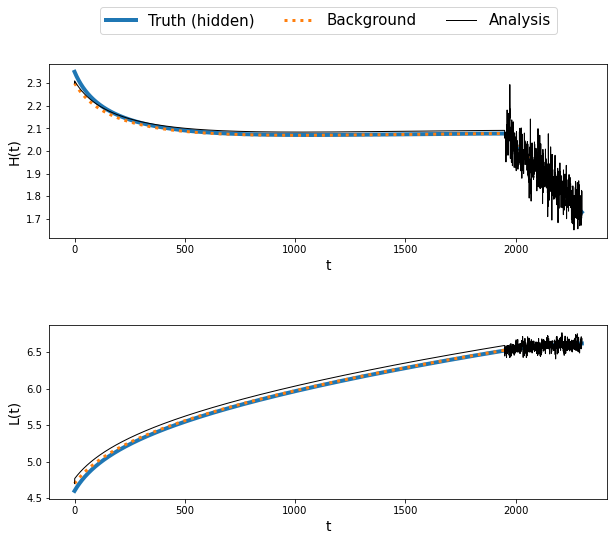

In [14]:
print("Number of observations since 1950: ", ind_m_acc.size)
print("Mean of covariance norms: ", round(np.mean(p),7))
print("Variance of covariance norms: ", round(np.var(p),7))
print("minimum: ", round(np.min(p),7))
print("maximum: ", round(np.max(p),7), " - note: all rounded to 7 significant digits")

fig, ax = plt.subplots(nrows=nd,ncols=1, figsize=(10,8))
ax = ax.flat

for k in range(nd):
    ax[k].plot(t,uTrue[k,:], label='Truth (hidden)', linewidth = 4)
    ax[k].plot(t,ub[k,:], ':', label='Background', linewidth = 3)
    '''ax[k].plot(t[ind_m],w[k,:], 'o', fillstyle='none', \
               label='Observations', markersize = 8, markeredgewidth = 2, color = 'g')''' # observations
    ax[k].set_xlabel('t',fontsize=14)
    #ax[k].axvspan(0, tm_m, color='y', alpha=0.4, lw=0)
    """for j in range(N):
        ax[k].plot(t[1:],uae[k,j,1:], '-', linewidth = 1, color='r') #the ensembles """
    ax[k].plot(t,ua[k,:], '-', label='Analysis', linewidth = 1, color = 'k')

ax[0].legend(loc="center", bbox_to_anchor=(0.5,1.25),ncol =4,fontsize=15)

ax[0].set_ylabel('H(t)', labelpad=5, fontsize=14)
ax[1].set_ylabel('L(t)', labelpad=5, fontsize=14)
#ax[2].set_ylabel('z(t)')
fig.subplots_adjust(hspace=0.5)

Number of observations since 1950:  1400
Uncertainty in Assimilation


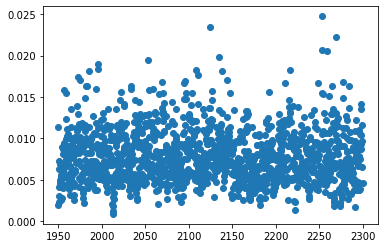

In [15]:
print("Number of observations since 1950: ", ind_m_acc.size)

print("Uncertainty in Assimilation")
plt.scatter(ind_m[:]/4,p[:])